# Data Preprocessing for Humpback Whale YouTube Video Dataset 

TO DO: 
- configure the cells above to convert urls-->mp4 files and upload videos onto google folder using drive API
    - extract metadata such as duration and title. Compile this info (mp4 name, title, duration) into a pandas dataframe and save as a csv file
- visualize duration of videos (rel vs non rel EDA continuation) --> use this info to determine at what x frame we want to extract the frame

### Step 1: Download YouTube videos from URLs onto Local Machine (or Google Drive)
- https://towardsdatascience.com/the-easiest-way-to-download-youtube-videos-using-python-2640958318ab

# Set Up
---

In [1]:
#to reflect changes made in modules
%load_ext autoreload
%autoreload 2

In [2]:
from pytube import YouTube

#misc
import os
import shutil
import math
import datetime

#plots
import matplotlib.pyplot as plt
%matplotlib inline

#pandas
import pandas as pd

#image operation
import cv2


# Counts of relevant and irrelevant Humpback Whale videos
--- 

### humpback_whale_videos_with_intervals.csv
- 113 relevant videos, 113 nonrelevant (226 total)
- cols:
    - duration_mins
    - duration_secs
    - relevant
    - num_frames
    - occurence_intervals

### EDA Plan (Conduct separately for relevant and non relevant)
- histograms of duration (print avg duration) --> use duration_mins for easier interpretability
- histograms of num_frames (print avg num_frames)

In [3]:
import pandas as pd
hw_data = pd.read_csv('humpback_whale_videos_with_intervals.csv')
hw_data.drop(columns=['Unnamed: 0'], inplace=True)

hw_data.head()

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked
0,Tom Mustill - Humpback Whales - A Detective St...,https://youtu.be/8j1HWD8KuMM,82,1909,True,video_0000.mp4,1.366667,2044,"[('0:00', '0:04'), ('0:30', '0:37'), ('1:11', ...",False
1,Suckling Humpback whale,https://youtu.be/tW_T8Z6ebmg,141,298156,True,video_0001.mp4,2.350000,0,"[('0:30', '0:40')]",False
2,Humpback Whales Lunge Feed Among Pod of Dolphi...,https://youtu.be/oSGhnD5kmAg,104,1117,True,video_0002.mp4,1.733333,3111,"[('0:00', '0:10'), ('0:42', '0:46')]",False
3,Humpback whales 2017 - Best of by Moorea Ocean...,https://youtu.be/6eWwFNq4i_c,224,2595,True,video_0003.mp4,3.733333,6719,"[('0:05', '0:20'), ('0:28', '0:33')]",False
4,Amazing! Humpback Whales Lunge Feeding up clos...,https://youtu.be/RMaMmynj76s,75,1005329,True,video_0004.mp4,1.250000,0,"[('0:00', '0:15'), ('0:35', '0:40')]",False


In [5]:
color_scheme = {'navy': '#34495e', 'muted_red': '#a34646', 'green': '#2f8045', 'orange': '#e74c3c' , 'purple': '#ab5fba', 'blue': '#319de0' }

def annotate_vertical_bars(plots):
    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        x_coord = bar.get_x() + bar.get_width() / 2
        y_coord = bar.get_height()

        plots.annotate(format(bar.get_height(), '.2f'),(x_coord, y_coord), 
                        ha='center', va='center', size=10, xytext=(0, 8), textcoords='offset points')

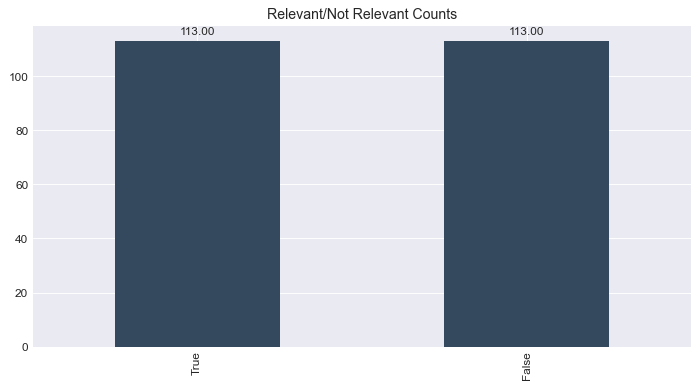

In [6]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid');
plt.figure(figsize=(10,5), dpi=85);

plots = hw_data['relevant'].value_counts().plot(kind = 'bar', title = 'Relevant/Not Relevant Counts', color=color_scheme['navy']);
annotate_vertical_bars(plots)


In [7]:
print(hw_data['relevant'].value_counts(), '\n')

True     113
False    113
Name: relevant, dtype: int64 



There are:
- 113 relevant videos
- 113 irrelevant videos

# Adding in more videos to our dataset (relevant + irrelevant - new_videos_to_add.csv) 
--- 

Since we are using this section to add on to and grow our existing dataset of 113 rel videos and 113 irrel videos, 
1. Load in 'humpback_whale_videos_with_intervals.csv' only to get a list of unique urls + make sure we don't add videos we already have --> get list of existing_urls
2. Load in 'humpback whales.csv', which contains all our urls available from our MongoDB collection (this is where we'll get new videos to grow our dataset from)

3. Specify how many additional relevant and irrelevant videos you want to add

4. ii = 621 (this will be for renaming our videos) 

5. While relevant count is not met:
    - find a new relevant video in Humpback Whales.csv (relevant==True and url not in existing_urls)
    - double check that video IS relevant
    - if video is relevant:
        - get + store occurence intervals

        - store: title, url, relevant, renamed_title, double_checked=True (all relevant), rand_sampled_intervals=None (all relevant)
    - if video is not relevant:
        - add video anyways, but as irrelevant

6. While irrelevant count is not met:
    - find a new irrelevant video
    - double check that video IS irrelevant   
        - if video is irrelevant: store ...


this assortment of new videos (rel + irrel) to add will be stored in a csv, 'new_videos_to_add_with_intervals.csv' , which is to be eventually concatenated with our main csv, 'humpback_whale_videos_with_intervals.csv' (after downloading the videos + getting duration/num_frames)

### Load in Data

In [3]:
## Load in data
## the csv with ALL humpback whale videos collected from youtube so far
humpback_whales_all = pd.read_csv('old csvs/humpback whales.csv') #1585 entries

## the curated csv with intervals (our main, functional csv)
hw_data_intervals = pd.read_csv('humpback_whale_videos_with_intervals.csv')
hw_data_intervals.drop(columns=['Unnamed: 0'], inplace=True)
hw_data_intervals.head()

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked,rand_sampled_intervals
0,Tom Mustill - Humpback Whales - A Detective St...,https://youtu.be/8j1HWD8KuMM,82,1909,True,video_0000.mp4,1.366667,2044,"[('0:00', '0:04'), ('0:30', '0:37'), ('1:11', ...",False,NaN
1,Suckling Humpback whale,https://youtu.be/tW_T8Z6ebmg,141,298156,True,video_0001.mp4,2.350000,0,"[('0:30', '0:40')]",False,NaN
2,Humpback Whales Lunge Feed Among Pod of Dolphi...,https://youtu.be/oSGhnD5kmAg,104,1117,True,video_0002.mp4,1.733333,3111,"[('0:00', '0:10'), ('0:42', '0:46')]",False,NaN
3,Humpback whales 2017 - Best of by Moorea Ocean...,https://youtu.be/6eWwFNq4i_c,224,2595,True,video_0003.mp4,3.733333,6719,"[('0:05', '0:20'), ('0:28', '0:33')]",False,NaN
4,Amazing! Humpback Whales Lunge Feeding up clos...,https://youtu.be/RMaMmynj76s,75,1005329,True,video_0004.mp4,1.250000,0,"[('0:00', '0:15'), ('0:35', '0:40')]",False,NaN


### Important Functions

In [4]:
#functions to double check relevance of each new potential video
from IPython.display import YouTubeVideo, Image, display, Video, HTML

def prompt_for_relevance_classification():
    ''' prompts user for decision on relevance/wild status of photographed encounter'''
    
    print("RELEVANT (enter y=yes/n=no):", end =" ")
    rel = True if input() == "y" else False
    return rel

def display_video(index, video_title, url):
    # display video - need to pass in videoID (at end of url) 
    print("{}: {}".format(index, video_title))
    print(url)
    videoID = url.split('/')[3]
    display(YouTubeVideo(videoID))

def get_occurence_intervals():
    '''allows user to enter occurence interval start + end time'''

    print('Recording occurence interval...\n')
    intervals = []
    
    #loop to allow recording of multiple intervals
    new_occurence = True
    i = 1
    while(new_occurence==True):
        print('Interval', i)
        start = input('Start Time:')
        end = input ('End Time: ')
        intervals.append((start, end))
        new_occurence = True if input('New Interval?(y/n)') =='y' else False
        i += 1
    print(intervals)

    return intervals 

### Getting Existing URLs and all relevant/irrelevant urls 

In [5]:
#get list of existing urls (226)
existing_urls = list(hw_data_intervals['url'])

#get df of unique all_relevant_urls available (859)
humpback_whales_all_relevant = humpback_whales_all[humpback_whales_all['relevant']==True].copy(deep=True)
humpback_whales_all_relevant.drop_duplicates(subset=['url'], inplace=True)
humpback_whales_all_relevant.reset_index(inplace=True)

#get df of unique all_irrelevant_urls available (726)
humpback_whales_all_irrelevant = humpback_whales_all[humpback_whales_all['relevant']==False].copy(deep=True)
humpback_whales_all_irrelevant.drop_duplicates(subset=['url'], inplace=True)
humpback_whales_all_irrelevant.reset_index(inplace=True)


In [9]:
import numpy as np
rel_count_goal   =  15 #200 - 113
irrel_count_goal = 7 #200 - 113
total_videos_to_add = rel_count_goal + irrel_count_goal
total_videos_to_add 

22

In [11]:
#where to store our newly gathered videos

# new_videos_to_add = pd.DataFrame({'title': [None for i in range(0, total_videos_to_add)],
#                                   'url': [None  for i in range(0, total_videos_to_add)],
#                                   'relevant': [None for i in range(0, total_videos_to_add)],
#                                   'occurence_intervals': [None for i in range(0, total_videos_to_add)],
#                                   'double_checked': [None for i in range(0, total_videos_to_add)],
#                                   'rand_sampled_intervals': [None for i in range(0, total_videos_to_add)]
#                                   })

new_videos_to_add = pd.read_csv('new_videos_to_add.csv')
new_videos_to_add.drop(columns=['Unnamed: 0'], inplace=True)
new_videos_to_add

,title,url,relevant,occurence_intervals,double_checked,rand_sampled_intervals
0,Humpback whale breach 7-10-14,https://youtu.be/I82N9I_SVmM,True,"[('0:30', '0:48')]",True,NaN
1,Whales-n-Sails flipper slapping humpback whale...,https://youtu.be/bE6FxjPbYcc,True,"[('0:36', '0:50')]",True,NaN
2,Whales-n-Sails humpback whales July 3/10,https://youtu.be/DIesiEj4XEw,True,"[('0:10', '0:17')]",True,NaN
3,Female Humpback Whale &quot;Sailing&quot; (Maui),https://youtu.be/CnHl9Zr_07Y,True,"[('0:30', '0:45')]",True,NaN
4,"2015 Sardine Run 10, Humpback Whale",https://youtu.be/qjg8n42JpUk,True,"[('0:00', '0:15')]",True,NaN
...,...,...,...,...,...,...
169,Unstoppable Pirahna Swarm FFA - deeeep.io,https://youtu.be/gKQ_WCURrCA,False,NaN,True,NaN
170,Deep Blue Ocean Sounds,https://youtu.be/BnKPCOiNGkc,False,NaN,True,NaN
171,Dr. Kent Hovind - Quick Announcement - Radio I...,https://youtu.be/a2KFDp5AWdc,False,NaN,True,NaN
172,Memories from spring 2019 - Orca Day with Vanc...,https://youtu.be/Y6mB9kDmn54,False,NaN,True,NaN


In [21]:
# #making space for more videos to get (since we weren't able to get all relevant/irrelevant videos)
# new_row = {'title': None, 'url': None, 'relevant': None, 'occurence_intervals': None, 'double_checke': None, 'rand_sampled_intervals': None}
# new_rows = [new_row for i in range(0, total_videos_to_add)]

# new_videos_to_add= new_videos_to_add.append(new_rows, ignore_index=True)
# new_videos_to_add

,title,url,relevant,occurence_intervals,double_checked,rand_sampled_intervals,double_checke
0,Humpback whale breach 7-10-14,https://youtu.be/I82N9I_SVmM,True,"[('0:30', '0:48')]",True,NaN,NaN
1,Whales-n-Sails flipper slapping humpback whale...,https://youtu.be/bE6FxjPbYcc,True,"[('0:36', '0:50')]",True,NaN,NaN
2,Whales-n-Sails humpback whales July 3/10,https://youtu.be/DIesiEj4XEw,True,"[('0:10', '0:17')]",True,NaN,NaN
3,Female Humpback Whale &quot;Sailing&quot; (Maui),https://youtu.be/CnHl9Zr_07Y,True,"[('0:30', '0:45')]",True,NaN,NaN
4,"2015 Sardine Run 10, Humpback Whale",https://youtu.be/qjg8n42JpUk,True,"[('0:00', '0:15')]",True,NaN,NaN
...,...,...,...,...,...,...,...
191,None,None,None,None,NaN,None,None
192,None,None,None,None,NaN,None,None
193,None,None,None,None,NaN,None,None
194,None,None,None,None,NaN,None,None


### Adding more relevant videos - new_videos_to_add.csv

In [27]:
new_count = 0

In [22]:
index_added = 0 + len(new_videos_to_add[(new_videos_to_add['relevant'] == True) | (new_videos_to_add['relevant'] == False)]) #make sure to update this if taking breaks + rerunning code below

In [48]:
start = 440
end = start + 10
print('start: {}\nend: {}\n'.format(start, end))
print('adding new videos into new_videos_to_add at index:', index_added)

start: 440
end: 450

adding new videos into new_videos_to_add at index: 185


already have url:  https://youtu.be/ohL1YqYlV4g
441: Swimming with Humpback Whales in Tonga
https://youtu.be/xy7v3Yb9shQ


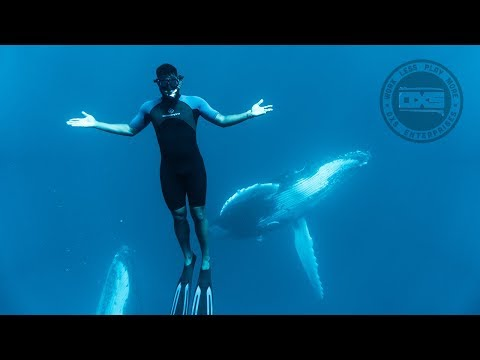

RELEVANT (enter y=yes/n=no): 

 y


Recording occurence interval...

Interval 1


Start Time: 1:15
End Time:  1:32
New Interval?(y/n) n


[('1:15', '1:32')]
442: Family rescues humpback whale entangled in fishing nets in Chile
https://youtu.be/KgPLcPAiYEE


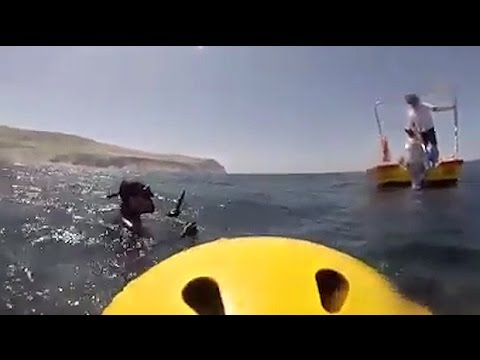

RELEVANT (enter y=yes/n=no): 

 y


Recording occurence interval...

Interval 1


Start Time: 0:30
End Time:  0:45
New Interval?(y/n) n


[('0:30', '0:45')]
443: Humpbacks Whales Throughout the Bay
https://youtu.be/7FTqmKssWy4


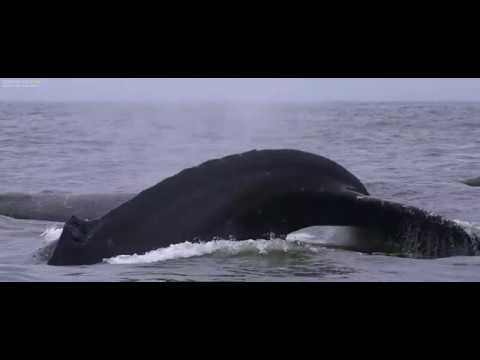

RELEVANT (enter y=yes/n=no): 

 y


Recording occurence interval...

Interval 1


Start Time: 0:00
End Time:  0:15
New Interval?(y/n) n


[('0:00', '0:15')]
444: Humpback Whale Takes a Giant Leap, Stuns Boaters Off Cape Henry
https://youtu.be/csm_1p1sU8o


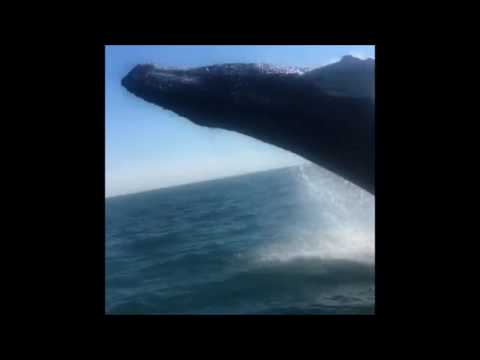

RELEVANT (enter y=yes/n=no): 

 y


Recording occurence interval...

Interval 1


Start Time: 1:00
End Time:  1:15
New Interval?(y/n) n


[('1:00', '1:15')]


In [49]:
#adding more relevant videos 
#switch back to all_relevant when done
for index, row in humpback_whales_all_relevant[start:end+1].iterrows():
    
    #check if we have met our goal yet
    count_new_rel_videos = len(new_videos_to_add[new_videos_to_add['relevant'] == True])
    if (count_new_rel_videos == rel_count_goal) or (new_count == rel_count_goal):
        break

    # check that we don't already have that url
    if (row['url'] not in existing_urls) and (row['url'] not in list(new_videos_to_add['url'])):

        #double check that url is relevant
        display_video(index, row['title.original'], row['url'])
        rel = prompt_for_relevance_classification()

        #if url is truly relevant, get occurence intervals + add into our dataframe
        if rel == True:
            new_videos_to_add.at[index_added, ('title')] = row['title.original']
            new_videos_to_add.at[index_added, ('url')] = row['url']
            new_videos_to_add.at[index_added, ('relevant')] = rel

            new_videos_to_add.at[index_added, ('occurence_intervals')] = get_occurence_intervals()
            new_videos_to_add.at[index_added, ('double_checked')] = True

            index_added += 1
            new_count += 1
    else:
        print('already have url: ', row['url'])

In [54]:
new_videos_to_add[184:190]

,title,url,relevant,occurence_intervals,double_checked,rand_sampled_intervals,double_checke
184,"Humpback Whale Feeding: Listening, Watching, P...",https://youtu.be/ohL1YqYlV4g,True,"[(0:08, 0:23)]",True,None,None
185,Swimming with Humpback Whales in Tonga,https://youtu.be/xy7v3Yb9shQ,True,"[(1:15, 1:32)]",True,None,None
186,Family rescues humpback whale entangled in fis...,https://youtu.be/KgPLcPAiYEE,True,"[(0:30, 0:45)]",True,None,None
187,Humpbacks Whales Throughout the Bay,https://youtu.be/7FTqmKssWy4,True,"[(0:00, 0:15)]",True,None,None
188,"Humpback Whale Takes a Giant Leap, Stuns Boate...",https://youtu.be/csm_1p1sU8o,True,"[(1:00, 1:15)]",True,None,None
189,None,None,None,None,NaN,None,None


In [56]:
#save csv with new videos to add
new_videos_to_add.to_csv('new_videos_to_add.csv')

### Adding Irrelevant videos - new_videos_to_add.csv

In [58]:
# print('{} irrelevant videos to gather!'.format(irrel_count_goal - len(new_videos_to_add[new_videos_to_add['relevant'] == False])))
# # len(new_videos_to_add[new_videos_to_add['relevant'] == False]) 

In [61]:
new_count = 0

In [72]:
start = 230
end = start + 25
index_added = 0 + len(new_videos_to_add[(new_videos_to_add['relevant'] == True) | (new_videos_to_add['relevant'] == False)]) #make sure to update this if taking breaks + rerunning code below
print('start: {}\nend: {}\n'.format(start, end))
print('adding new videos into new_videos_to_add at index:', index_added)

start: 230
end: 255

adding new videos into new_videos_to_add at index: 189


230: Pines and Palms - Isalmorada
https://youtu.be/oXo6pgNsQlE


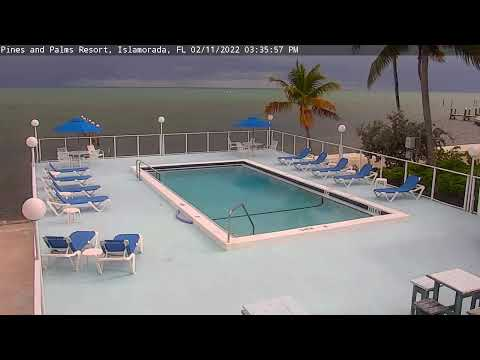

RELEVANT (enter y=yes/n=no): 

 y


231: The MOST CREEPY SOUND!! ever recorded in the deep ocean I Top10
https://youtu.be/J7wBGRY3380


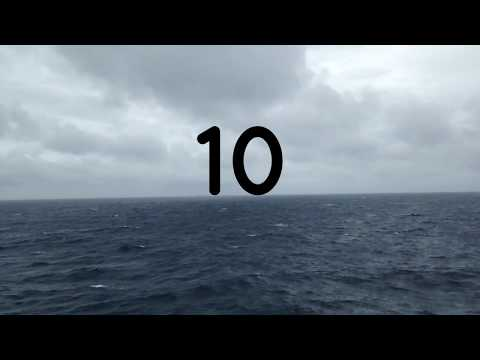

RELEVANT (enter y=yes/n=no): 

 n


232: 10 Strange Things Encountered By Divers
https://youtu.be/DO6O6FY66VI


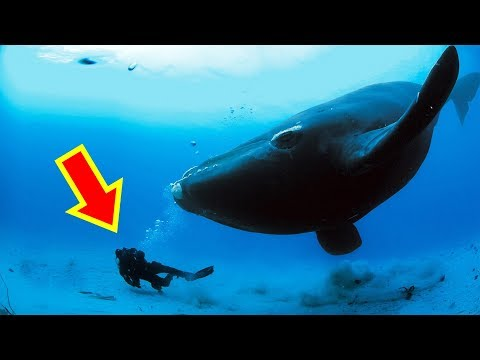

RELEVANT (enter y=yes/n=no): 

 y


233: Top 10 LOUDEST Sounds Ever Heard
https://youtu.be/JEtGdOfrnBA


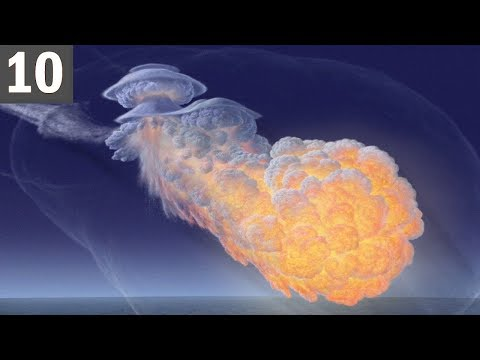

RELEVANT (enter y=yes/n=no): 

 n


234: STRANGEST Things Found Washed Up On Shore!
https://youtu.be/OeSTDB_uDlg


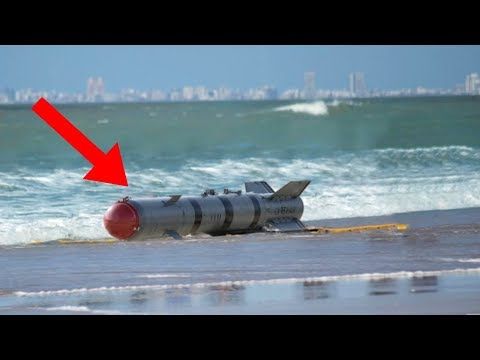

RELEVANT (enter y=yes/n=no): 

 y


235: TOP 10 LARGEST ANIMALS On The Planet
https://youtu.be/NAGQJTKEQ_s


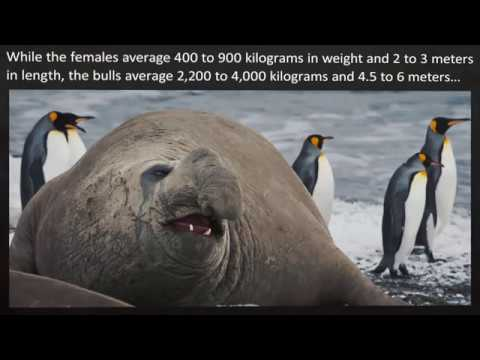

RELEVANT (enter y=yes/n=no): 

 n


236: Sea World Cruises | Whale Watching | Experience Oz
https://youtu.be/j6DZRmYYmcQ


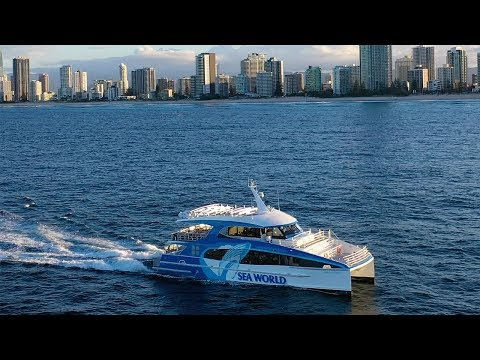

RELEVANT (enter y=yes/n=no): 

 y


237: &#39;This is Gross&#39;: Humpback Whale Carcass Liquids Bubble Up on Samoa Beach
https://youtu.be/pXztGhYJXDI


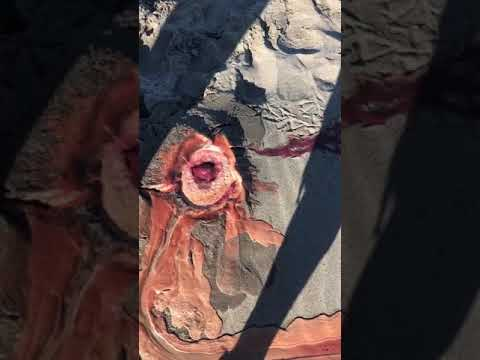

RELEVANT (enter y=yes/n=no): 

 n


238: Humpback whale says hello to people on a boat off the coast of St Andrews, New Brunswick, Canada
https://youtu.be/STGHuKrPWJY


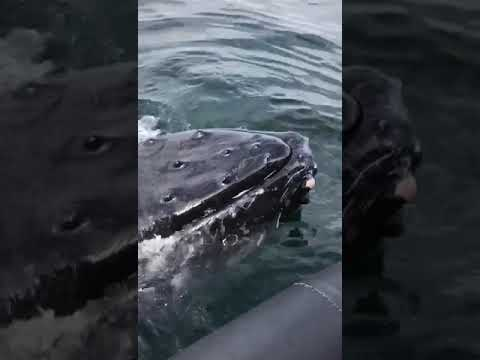

RELEVANT (enter y=yes/n=no): 

 y


239: Best Antarctic Animal Moments | Top 5 | BBC Earth
https://youtu.be/LBbWVw1kp5Q


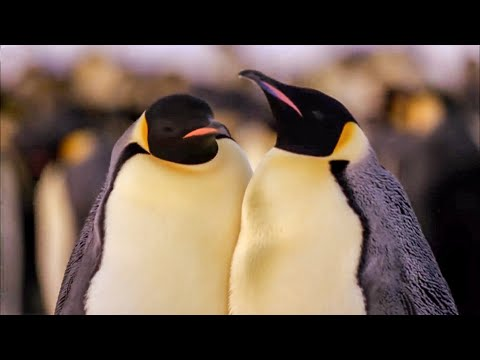

RELEVANT (enter y=yes/n=no): 

 y


240: Juvenile Humpback Whale Strands on Oregon Coast
https://youtu.be/7IZnmD1St4E


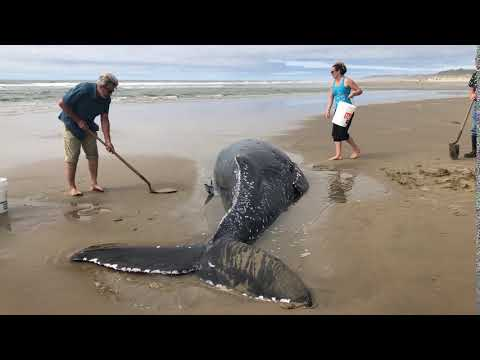

RELEVANT (enter y=yes/n=no): 

 y


241: Top 10 Largest Animals::The Biggest Living Animals:: World Largest living things.
https://youtu.be/Snih6bcYIlw


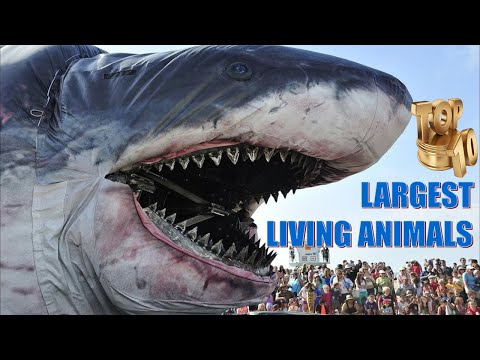

RELEVANT (enter y=yes/n=no): 

 y


242: RC Adventure Jeep Wrangler Axial SCX10 - The humpback whale rock
https://youtu.be/YjY6PQqqMBg


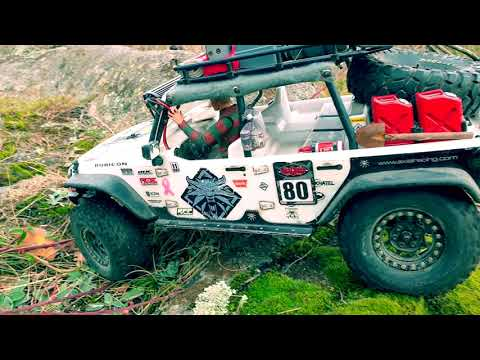

RELEVANT (enter y=yes/n=no): 

 n


243: Top 10 small pigy animal in world
https://youtu.be/uKMJs4MGMEA


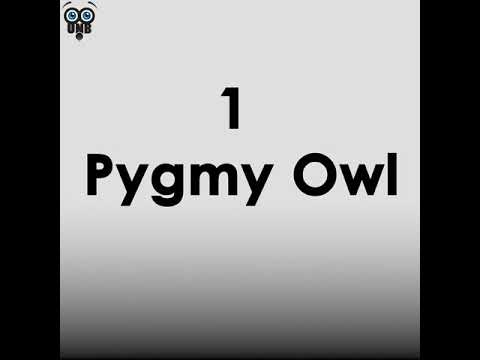

RELEVANT (enter y=yes/n=no): 

 n


244: Whale watching top 10!!!
https://youtu.be/dFY4jiiQ2QQ


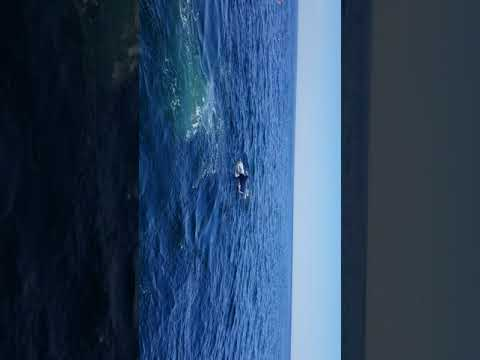

RELEVANT (enter y=yes/n=no): 

 y


245: The Largest Sea Animals In The World || Top 10 series || series #2
https://youtu.be/lSPh21Uo8Jo


RELEVANT (enter y=yes/n=no): 

 y


246: Distressed humpback tangled in fishing net off San Diego&#39;s coast
https://youtu.be/1i9r8x5sXCU


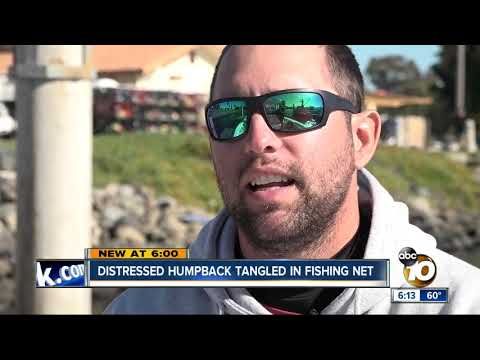

RELEVANT (enter y=yes/n=no): 

 y


247: 10 Wild Animals that saved lives
https://youtu.be/a7mhezxMwPE


RELEVANT (enter y=yes/n=no): 

 y


248: သားရဲတို့က ကယ်တင်လိုက်တဲ့လူသားများ (Top 10)
https://youtu.be/LqbzvffOmjc


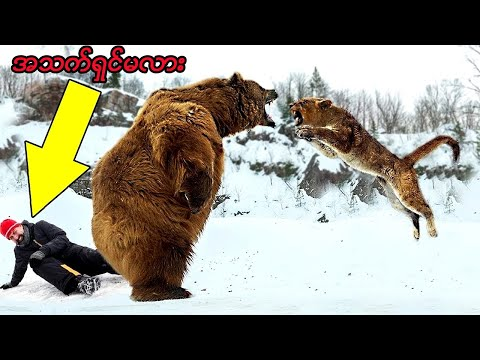

RELEVANT (enter y=yes/n=no): 

 y


249: Top 10 Largest Animal In The World
https://youtu.be/dsZvXl712q0


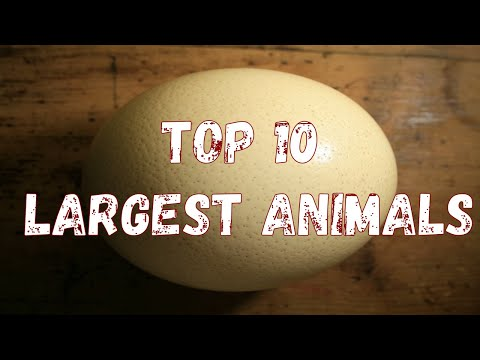

RELEVANT (enter y=yes/n=no): 

 y


250: TOP 10 STRONGEST AND WEIRDEST SEA ANIMALS!🐬🐋🐳
https://youtu.be/m8xoPccr1cY


RELEVANT (enter y=yes/n=no): 

 y


251: TOP 10 most powerful animals of the planet !!!
https://youtu.be/OpGMMWUY5LQ


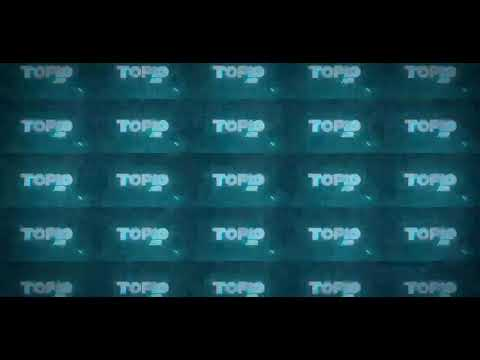

RELEVANT (enter y=yes/n=no): 

 y


252: Iceland: Top 10 Destination
https://youtu.be/xzBSPM2GppA


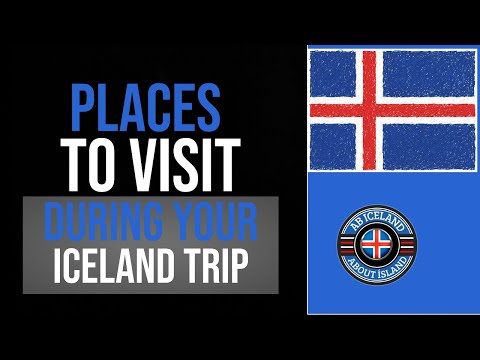

RELEVANT (enter y=yes/n=no): 

 n


253: Top 10 Biggest Animal in the World
https://youtu.be/J_UF5cajbxo


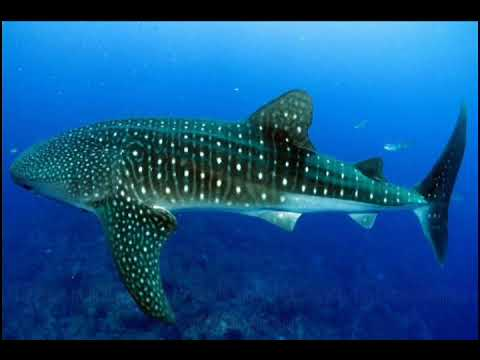

RELEVANT (enter y=yes/n=no): 

 n


254: Top 10 Heaviest Animals in the World
https://youtu.be/nw4r9cT3SZs


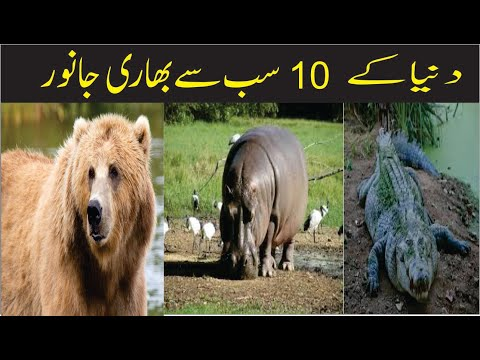

RELEVANT (enter y=yes/n=no): 

 y


255: TOP 10 BIGGEST ANIMALS IN THE WORLD 2020
https://youtu.be/9208TjRTpNA


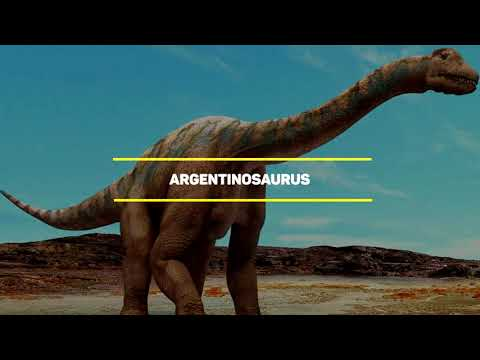

RELEVANT (enter y=yes/n=no): 

 y


In [73]:
#adding more irrelevant videos
for index, row in humpback_whales_all_irrelevant[start:end+1].iterrows():
    
    #check if we have met our goal yet
    count_new_irrel_videos = len(new_videos_to_add[new_videos_to_add['relevant'] == False])
    if (count_new_irrel_videos == irrel_count_goal) or (new_count == irrel_count_goal):
        break

    # check that we don't already have that url
    if (row['url'] not in existing_urls) and (row['url'] not in list(new_videos_to_add['url'])):

        #double check that url is irrelevant
        display_video(index, row['title.original'], row['url'])
        rel = prompt_for_relevance_classification()

        #if url is truly relevant, get occurence intervals + add into our dataframe
        if rel == False:
            new_videos_to_add.at[index_added, ('title')] = row['title.original']
            new_videos_to_add.at[index_added, ('url')] = row['url']
            new_videos_to_add.at[index_added, ('relevant')] = rel
            new_videos_to_add.at[index_added, ('double_checked')] = True

            index_added += 1
    else:
        print('already have url ', row['url'])

In [76]:
new_videos_to_add[-5:]

,title,url,relevant,occurence_intervals,double_checked,rand_sampled_intervals,double_checke
192,&#39;This is Gross&#39;: Humpback Whale Carcas...,https://youtu.be/pXztGhYJXDI,False,None,True,None,None
193,RC Adventure Jeep Wrangler Axial SCX10 - The h...,https://youtu.be/YjY6PQqqMBg,False,None,True,None,None
194,Top 10 small pigy animal in world,https://youtu.be/uKMJs4MGMEA,False,None,True,None,None
195,Iceland: Top 10 Destination,https://youtu.be/xzBSPM2GppA,False,None,True,None,None
196,Top 10 Biggest Animal in the World,https://youtu.be/J_UF5cajbxo,False,NaN,True,NaN,NaN


In [78]:
#save csv with new videos to add
new_videos_to_add.to_csv('new_videos_to_add.csv')

# Finding Humpback Whale Occurence Intervals (Manually - humpback_whale_videos_with_intervals.csv )

---

1. Manually filter each relevant video to find frames that contain humpback whales
    1. For video in dataset:
         - Display video
         - if relevant:
            - Find + Annotate 3-10 second interval of HW encounter
            - Store intervals in csv
        - if not relevant:
            - add to csv  


2. For relevant videos, crop videos at intervals + extract frames from resulting clips
3. For irrelevant videos, crop a random 15 sec interval + extract frames from here (if we do EDA and decide on a number of clips to extract per video, then we can skip finding a 15 second video and just get the n number of frames from that video)

## Loading in Dataset ...

In [93]:
# hw_data = pd.read_csv('humpback_whale_videos_with_intervals.csv')
# hw_data.drop(columns=['Unnamed: 0'], inplace=True)
hw_data.head()

# hw_data.columns

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked
0,Tom Mustill - Humpback Whales - A Detective St...,https://youtu.be/8j1HWD8KuMM,82,1909,True,video_0000.mp4,1.366667,2044,"[('0:00', '0:04'), ('0:30', '0:37'), ('1:11', ...",False
1,Suckling Humpback whale,https://youtu.be/tW_T8Z6ebmg,141,298156,True,video_0001.mp4,2.350000,0,"[('0:30', '0:40')]",False
2,Humpback Whales Lunge Feed Among Pod of Dolphi...,https://youtu.be/oSGhnD5kmAg,104,1117,True,video_0002.mp4,1.733333,3111,"[('0:00', '0:10'), ('0:42', '0:46')]",False
3,Humpback whales 2017 - Best of by Moorea Ocean...,https://youtu.be/6eWwFNq4i_c,224,2595,True,video_0003.mp4,3.733333,6719,"[('0:05', '0:20'), ('0:28', '0:33')]",False
4,Amazing! Humpback Whales Lunge Feeding up clos...,https://youtu.be/RMaMmynj76s,75,1005329,True,video_0004.mp4,1.250000,0,"[('0:00', '0:15'), ('0:35', '0:40')]",False


In [94]:
#adding occurence intervals column (note: only need to run ONCE)
# hw_data['occurence_intervals'] = [None for i in range(0, len(hw_data))]
# hw_data['occurence_intervals'].astype('object')
# hw_data.head()

In [95]:
#get amount of entries with occurence intervals
hw_data[hw_data['occurence_intervals'].notnull()] #to find entries WITH occurence intervals

#get amount of entries with occurence intervals
# hw_data[hw_data['occurence_intervals'].isnull()] #to find entries WITHOUT occurence intervals

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked
0,Tom Mustill - Humpback Whales - A Detective St...,https://youtu.be/8j1HWD8KuMM,82,1909,True,video_0000.mp4,1.366667,2044,"[('0:00', '0:04'), ('0:30', '0:37'), ('1:11', ...",False
1,Suckling Humpback whale,https://youtu.be/tW_T8Z6ebmg,141,298156,True,video_0001.mp4,2.350000,0,"[('0:30', '0:40')]",False
2,Humpback Whales Lunge Feed Among Pod of Dolphi...,https://youtu.be/oSGhnD5kmAg,104,1117,True,video_0002.mp4,1.733333,3111,"[('0:00', '0:10'), ('0:42', '0:46')]",False
3,Humpback whales 2017 - Best of by Moorea Ocean...,https://youtu.be/6eWwFNq4i_c,224,2595,True,video_0003.mp4,3.733333,6719,"[('0:05', '0:20'), ('0:28', '0:33')]",False
4,Amazing! Humpback Whales Lunge Feeding up clos...,https://youtu.be/RMaMmynj76s,75,1005329,True,video_0004.mp4,1.250000,0,"[('0:00', '0:15'), ('0:35', '0:40')]",False
...,...,...,...,...,...,...,...,...,...,...
118,Top 10 Tourist Attractions in Alaska's Inside ...,https://youtu.be/YcvV3HkzC-g,512,2631,True,video_0121.mp4,8.533333,12787,"[('3:01', '3:18')]",True
124,Orca Killer whale killing a humpback whale cal...,https://youtu.be/DfLEqqh-unM,64,7693,True,video_0128.mp4,1.066667,3853,"[('0:39', '0:49')]",True
133,Rescuers free humpback whale tangled in fishin...,https://youtu.be/QkdLwpdJ4FM,170,485,True,video_0137.mp4,2.833333,5101,"[('0:20', '0:25'), ('0:35', '0:42')]",True
139,Killer Whales feed on carcass with Humpback Wh...,https://youtu.be/OoeAGM8Sxro,395,26574,True,video_0143.mp4,6.583333,9473,"[('0:08', '0:20')]",True


## Annotating Occurence Intervals for Known Relevant Videos in CSV

In [222]:
# start = 97
# end = start + 3

In [226]:
## Annotating occurence intervals in known relevant videos
# from IPython.display import YouTubeVideo, Image, display, Video

# for index, row in hw_data[start: end+1].iterrows():
    
#     #display video - need to pass in videoID (at end of url) 
#     print("{}: {}".format(index, row['renamed_title']))
#     print(row['url'])
#     videoID = row['url'].split('/')[3]
#     display(YouTubeVideo(videoID)) 
    
    
#     #use index to insert occurence interval start + end time
#     print('Recording occurence interval...\n')
#     intervals = []
    
#     #loop to allow recording of multiple intervals
#     new_occurence = True
#     i = 1
#     while(new_occurence==True):
#         print('Interval', i)
#         start = input('Start Time:')
#         end = input ('End Time: ')
#         intervals.append((start, end))
#         new_occurence = True if input('New Interval?(y/n)') =='y' else False
#         i += 1
#     print(intervals)
#     hw_data.at[index, ('occurence_intervals')] = intervals    

In [231]:
# after running video interval filtration on first two entries only
# note: we only want about 10-15 seconds of video clips from each video
hw_data.head()

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals
0,Tom Mustill - Humpback Whales - A Detective St...,https://youtu.be/8j1HWD8KuMM,82,1909,True,video_0000.mp4,1.366667,2044,"[(0:00, 0:04), (0:30, 0:37), (1:11, 1:14)]"
1,Suckling Humpback whale,https://youtu.be/tW_T8Z6ebmg,141,298156,True,video_0001.mp4,2.350000,0,"[(0:30, 0:40)]"
2,Humpback Whales Lunge Feed Among Pod of Dolphi...,https://youtu.be/oSGhnD5kmAg,104,1117,True,video_0002.mp4,1.733333,3111,"[(0:00, 0:10), (0:42, 0:46)]"
3,Humpback whales 2017 - Best of by Moorea Ocean...,https://youtu.be/6eWwFNq4i_c,224,2595,True,video_0003.mp4,3.733333,6719,"[(0:05, 0:20), (0:28, 0:33)]"
4,Amazing! Humpback Whales Lunge Feeding up clos...,https://youtu.be/RMaMmynj76s,75,1005329,True,video_0004.mp4,1.250000,0,"[(0:00, 0:15), (0:35, 0:40)]"


In [218]:
# index = #
# hw_data.at[index, ('occurence_intervals')] = #[('0:00', '0:05'), ('0:48', '0:54'), ('5:35', '5:42')]
# hw_data.loc[index]

Download/save_csv with occurence intervals

In [233]:
## will resave once all entries have been filtered/in between stopping points
hw_data.to_csv('humpback_whale_videos_with_intervals.csv')

## Double Checking Irrelevant Videos in CSV + Updating accordingly

In [237]:
def prompt_for_relevance_classification():
    ''' prompts user for decision on relevance/wild status of photographed encounter'''
    
    print("RELEVANT (enter y=yes/n=no):", end =" ")
    rel = True if input() == "y" else False
    return rel

In [279]:
hw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                145 non-null    object 
 1   url                  145 non-null    object 
 2   duration_seconds     145 non-null    int64  
 3   views                145 non-null    int64  
 4   relevant             145 non-null    bool   
 5   renamed_title        145 non-null    object 
 6   duration_mins        145 non-null    float64
 7   num_frames           145 non-null    int64  
 8   occurence_intervals  113 non-null    object 
 9   double_checked       145 non-null    bool   
dtypes: bool(2), float64(1), int64(3), object(4)
memory usage: 9.5+ KB


In [280]:
start = 141
end = 144

141: video_0145.mp4
https://youtu.be/tBrxJMwLdfA


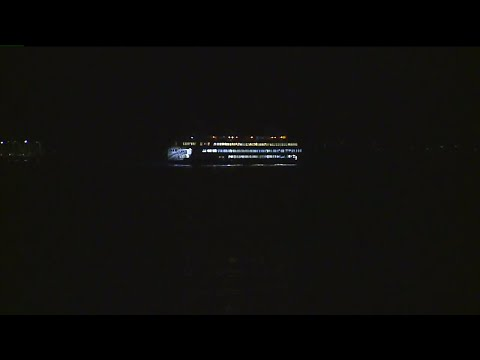

RELEVANT (enter y=yes/n=no):  n
142: video_0146.mp4
https://youtu.be/IigXYyw1WRs


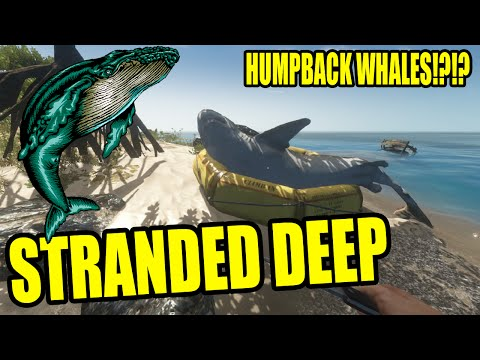

RELEVANT (enter y=yes/n=no):  n
143: video_0147.mp4
https://youtu.be/FbMmdVdKT24


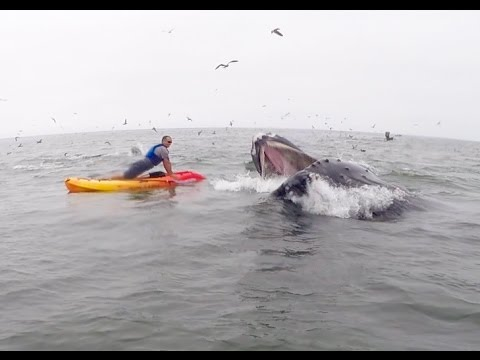

RELEVANT (enter y=yes/n=no):  y
Recording occurence interval...

Interval 1
Start Time: 0:25
End Time:  0:38
New Interval?(y/n) n
[('0:25', '0:38')]
144: video_0148.mp4
https://youtu.be/zVrFxlV2GSo


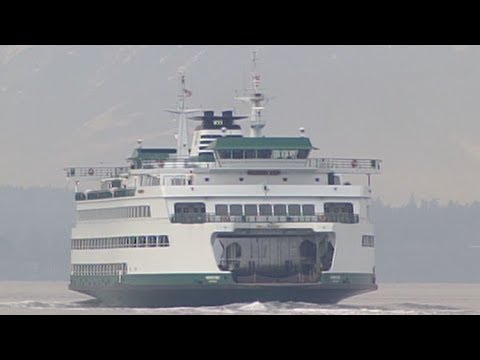

RELEVANT (enter y=yes/n=no):  n


In [281]:
## double checking irrelevant videos (+ updating with occurence intervals if video turns out to be relevant)
## videos originally marked irrelevant start at index = 100 in CSV (and dataframe)

from IPython.display import YouTubeVideo, Image, display, Video

for index, row in hw_data[start: end+1].iterrows():
    
    #display video - need to pass in videoID (at end of url) 
    print("{}: {}".format(index, row['renamed_title']))
    print(row['url'])
    videoID = row['url'].split('/')[3]
    display(YouTubeVideo(videoID))
    
    #prompt for relevance classification
    relevant = prompt_for_relevance_classification()
    hw_data.at[index, ('relevant')] = relevant
    
    
    #if video is updated + marked as rel, record occurence intervals
    if relevant == True:
        #use index to insert occurence interval start + end time
        print('Recording occurence interval...\n')
        intervals = []

        #loop to allow recording of multiple intervals
        new_occurence = True
        i = 1
        while(new_occurence==True):
            print('Interval', i)
            start_time = input('Start Time:')
            end_time = input ('End Time: ')
            intervals.append((start_time, end_time))
            new_occurence = True if input('New Interval?(y/n)') =='y' else False
            i += 1
        print(intervals)
        hw_data.at[index, ('occurence_intervals')] = intervals
    
    #marked video double_checked (just to keep track of double checked irrelevant videos)
    hw_data.at[index, ('double_checked')] = True

A video is RELEVANT if it documents **an ENCOUNTER** with a humpback whale.

A video is IRRELEVANT if we cannot be sure the animal is a humpback whale indeed, if the video documents a carcass (being examined), or if no real humpback whale is documented

In [282]:
hw_data[start:end+2]

,title,url,duration_seconds,views,relevant,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked
141,Ferry hits humpback whale in Elliott Bay,https://youtu.be/tBrxJMwLdfA,90,293,False,video_0145.mp4,1.500000,2664,None,True
142,Stranded Deep | SHARK HUNTING AND HUMPBACK WHA...,https://youtu.be/IigXYyw1WRs,1150,53052,False,video_0146.mp4,19.166667,34458,None,True
143,Humpback Whale Crashes 22 for 22 Pushup Challe...,https://youtu.be/FbMmdVdKT24,87,122545,True,video_0147.mp4,1.450000,2593,"[(0:25, 0:38)]",True
144,Washington state ferry hits a humpback whale i...,https://youtu.be/zVrFxlV2GSo,588,4458,False,video_0148.mp4,9.800000,17623,None,True


**Download Updated CSV**

In [206]:
## will resave once all entries have been filtered/in between stopping points
hw_data.to_csv('humpback_whale_videos_with_intervals.csv')

 Update Jan 24, 2022: Finished filtering irrelevant videos + updating newly relevant videos with occurence intervals